In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')
import networkx as nx
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from datetime import datetime


In [3]:
case =  pd.read_csv('Korea_dataset/Case.csv')
patient_info = pd.read_csv('Korea_dataset/PatientInfo.csv')
patient_route = pd.read_csv('Korea_dataset/PatientRoute.csv')

In [4]:
case.head()

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Guro-gu,True,Guro-gu Call Center,98,37.508163,126.884387
1,1000002,Seoul,Dongdaemun-gu,True,Dongan Church,20,37.592888,127.056766
2,1000003,Seoul,Guro-gu,True,Manmin Central Church,41,37.481059,126.894343
3,1000004,Seoul,Eunpyeong-gu,True,Eunpyeong St. Mary's Hospital,14,37.63369,126.9165
4,1000005,Seoul,Seongdong-gu,True,Seongdong-gu APT,13,37.55713,127.0403


In [5]:
patient_info.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [6]:
patient_route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534


In [7]:
def normalize_me(mlist):
    max_ = max(mlist)
    min_ = min(mlist)
    normalized_list = []
    for i in range(len(mlist)):
        normalized_list.append((mlist[i]-min_)/(max_-min_))
    return normalized_list

## Basic Visualizations

At this point we will provide some basic visualizations to the dataset in order to see basic statistical figures

,confirmed_date,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,released_date,deceased_date,state
0,2020-01-20,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,0,1
1,2020-01-23,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1
2,2020-01-26,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,0,1
3,2020-01-27,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,0,1
4,2020-01-30,3,3,3,3,3,3,3,3,0,3,3,1,3,1,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2020-04-15,14,5,12,12,12,14,14,14,0,14,0,8,3,2,0,0,14
73,2020-04-16,8,3,7,5,7,8,8,6,0,8,0,3,2,1,0,0,8
74,2020-04-17,11,8,8,8,8,11,11,11,0,11,0,6,3,0,0,0,11
75,2020-04-18,5,2,4,4,4,5,5,5,0,5,0,1,2,1,0,0,5


In [38]:
incidents = list(patient_info.groupby('confirmed_date').size())
dates = list(patient_info.groupby('confirmed_date').count().reset_index()['confirmed_date'])
patient_info_timeseries = pd.DataFrame(dates, columns=['date'])
patient_info_timeseries['incidents'] = incidents

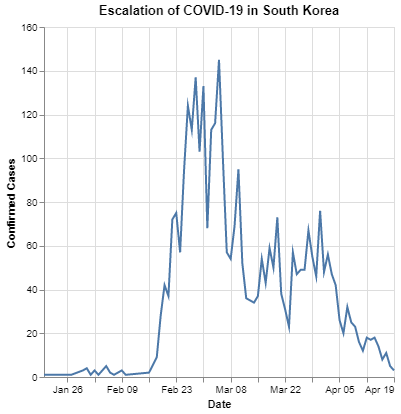

In [39]:
alt.Chart(patient_info_timeseries).mark_line().encode(
    x = alt.X('date:T',axis = alt.Axis(title = 'Date')),
    y = alt.Y('incidents:Q',axis = alt.Axis(title = 'Confirmed Cases'))
).properties(
    width = 350,
    height = 350,
    title = 'Escalation of COVID-19 in South Korea'
)

In [8]:
patient_info_data = patient_info.dropna(subset=['age','sex'])

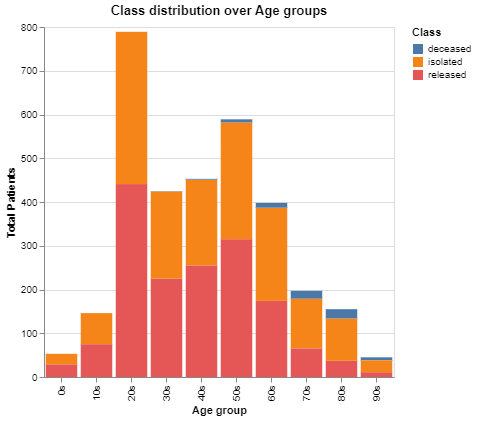

In [9]:
alt.Chart(patient_info_data[patient_info_data['age'] != '100s']).mark_bar().encode(
    x = alt.X('age:N',axis = alt.Axis(title = 'Age group')),
    y = alt.Y('count():Q',axis = alt.Axis(title = 'Total Patients')),
    color = alt.Color('state:N',legend=alt.Legend(title = 'Class'))
).properties(
    width = 350,
    height = 350,
    title = 'Class distribution over Age groups'
)

### Network creation for each province to show us the 'weak' places that covid-19 can be spreaded more easily

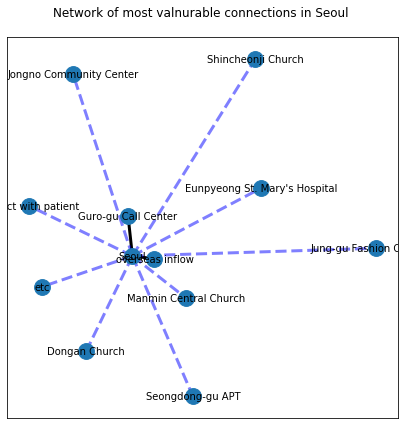

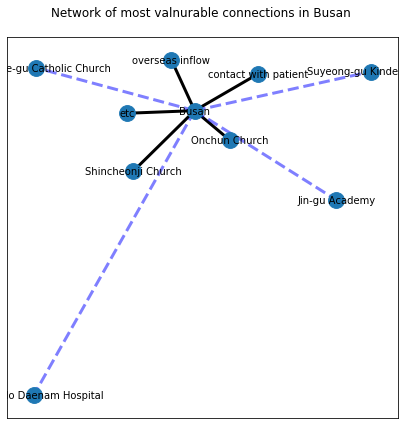

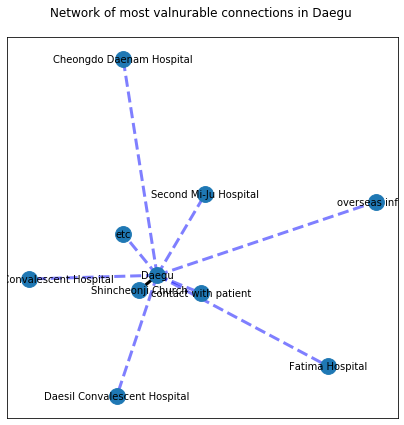

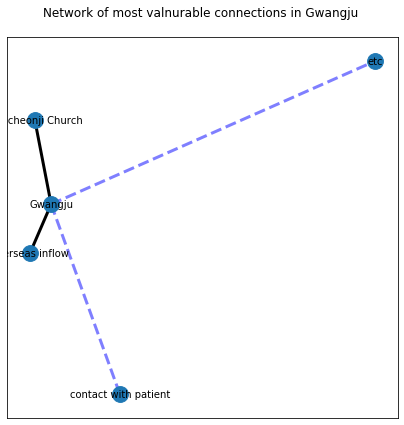

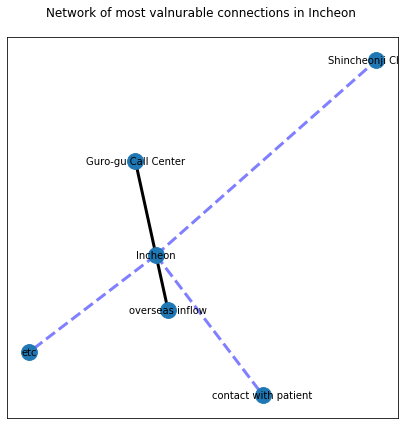

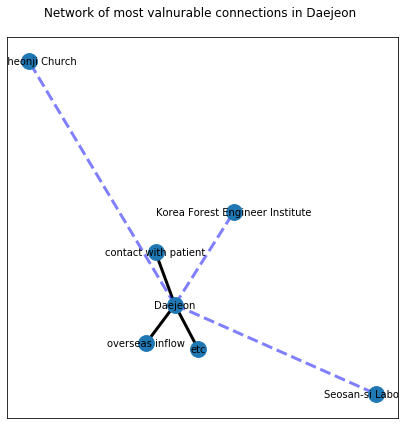

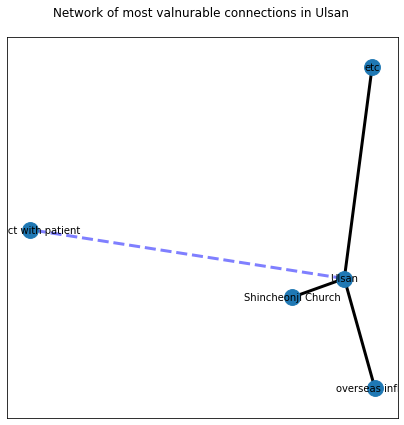

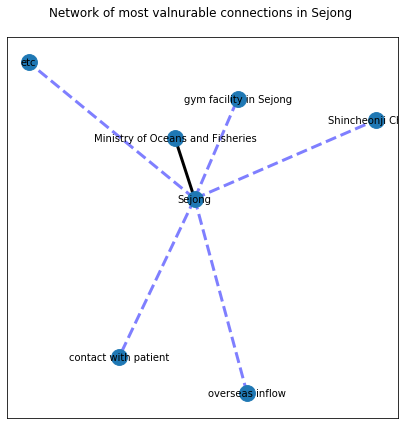

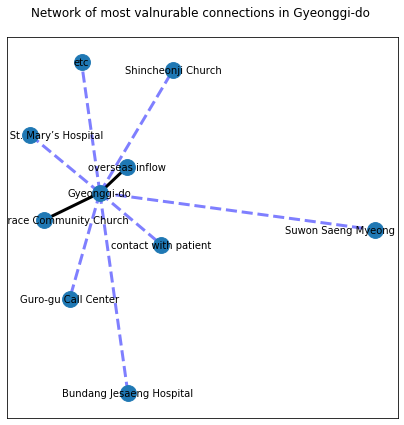

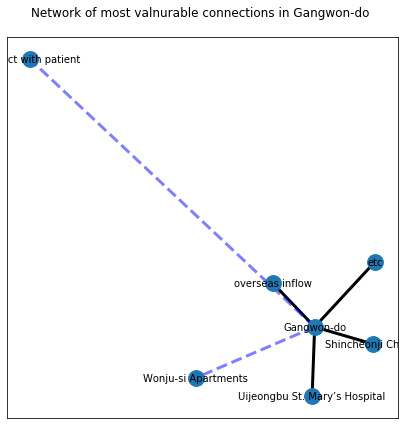

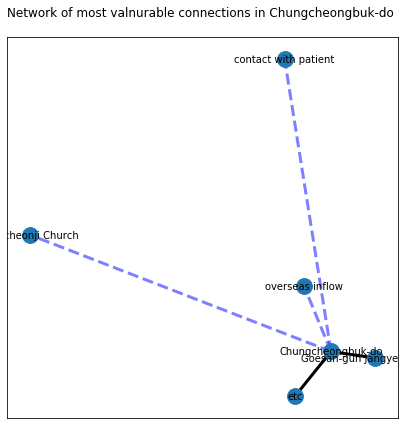

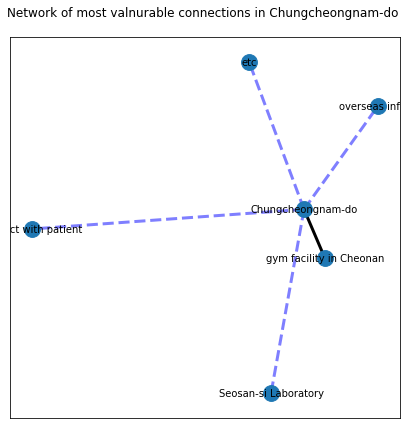

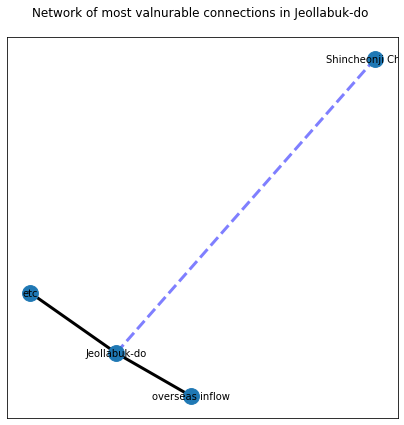

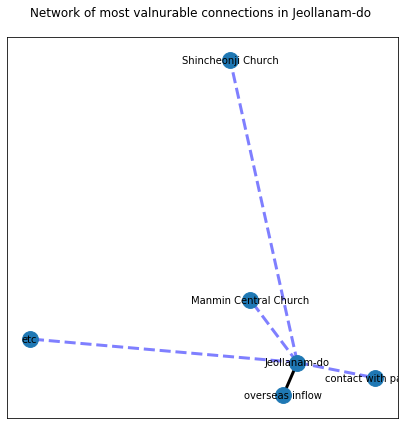

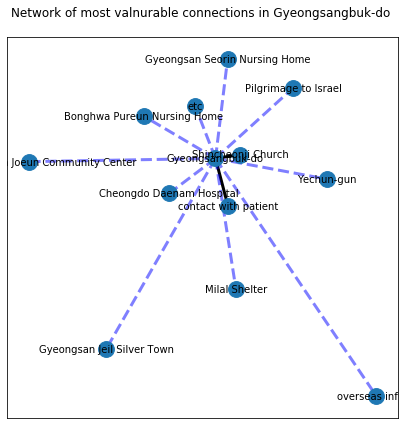

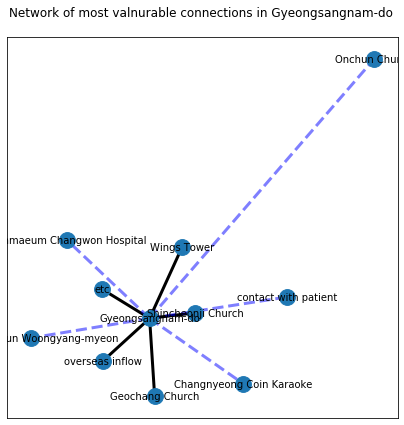

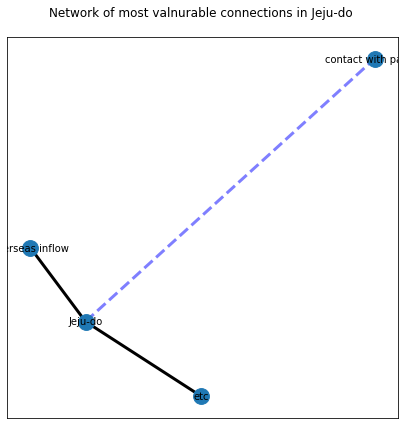

In [10]:
for province in case['province'].unique():
    subset = case[case['province'] == province].reset_index()
    nor_i = normalize_me(subset['confirmed'].tolist())
    subset['normalized_confirmed'] = nor_i
    G = nx.Graph()
    elarge = []
    esmall = []
    for i in range(subset.shape[0]):
        G.add_node(subset['province'][i])
        G.add_edge(subset['province'][i], subset['infection_case'][i],weight = subset['normalized_confirmed'][i])
        if subset['normalized_confirmed'][i]>= 0.25:
            elarge.append((subset['province'][i], subset['infection_case'][i]))
        else:
            esmall.append((subset['province'][i], subset['infection_case'][i]))
    pos = nx.spring_layout(G)  # positions for all nodes
    plt.figure(figsize=[7,7])
    plt.title('Network of most valnurable connections in {} \n'.format(province))
    nx.draw_networkx_nodes(G, pos, node_size=250)
    nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=3)
    nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=3, alpha=0.5, edge_color='b', style='dashed')
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    plt.show()

In [11]:
G2 = nx.Graph()
for i in range(patient_info.shape[0]):
    G2.add_node(patient_info['province'][i])   

In [12]:
subsub = patient_info
subsub['province'] = subsub['province'].astype('str')
mylist = []
for i in range(patient_route.shape[0]):
    subset = (subsub[patient_route['patient_id'][i] == subsub['patient_id']]['province'])
    start = subset.values[0]
    end = patient_route['province'][i]
    mylist.append((start,end))
index = []
for pos,item in enumerate(mylist):
    if item[0] == item[1]:
        index.append((item[0],item[1]))
for i in range(len(index)):
    mylist.remove(index[i])
my_dict = {i:mylist.count(i) for i in mylist}
numbers = [my_dict[item] for item in my_dict]
numbers = normalize_me(numbers)
esmall = []
emedium = []
elarge = []
for pos,item in enumerate(my_dict):
    my_dict[item] = numbers[pos]
    if my_dict[item] <= 0.10:
        esmall.append((item[0], item[1]))
    elif ((my_dict[item] >0.10 ) & (my_dict[item] <=.3)):
        emedium.append((item[0],item[1]))
    else:
        elarge.append((item[0],item[1]))
        

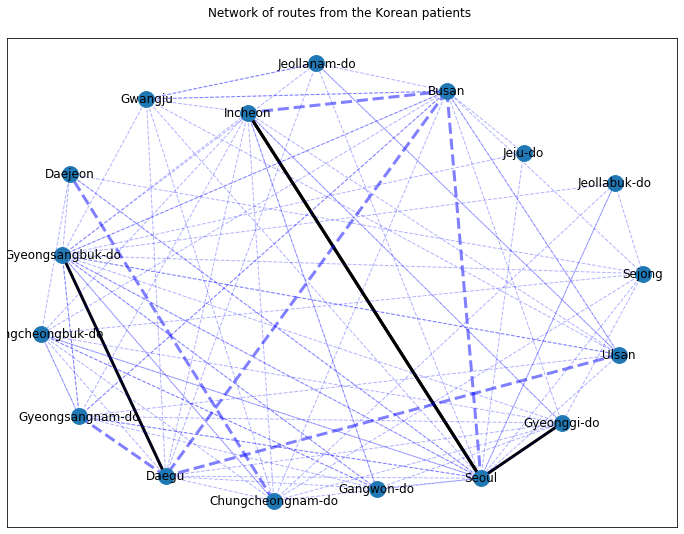

In [13]:
plt.figure(figsize=[12,9])
pos = nx.spring_layout(G2)  # positions for all nodes
nx.draw_networkx_nodes(G2, pos, node_size=250)
nx.draw_networkx_edges(G2, pos, edgelist=elarge,
                       width=3)
nx.draw_networkx_edges(G2, pos, edgelist=emedium,
                       width=3, alpha=0.5, edge_color='b', style='dashed')
nx.draw_networkx_edges(G2, pos, edgelist=esmall,
                       width=1, alpha=0.3, edge_color='b', style='dashed')
nx.draw_networkx_labels(G2, pos, font_size=12, font_family='sans-serif')
plt.title('Network of routes from the Korean patients \n')
plt.show()

In [14]:
def encode(x):
    if np.isnan(x):
        return 0
    else:
        return 1

In [15]:
def encode_v2(x):
    if x != 0:
        return 1
    else:
        return 0

In [16]:
def encode_sex(x):
    if x == 'male':
        return 0
    else:
        return 1

In [17]:
patient_info

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,7000000009,9651.0,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,14.0,NaN,2020-03-29,NaN,NaN,isolated
3322,7000000010,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,18.0,NaN,2020-04-03,NaN,NaN,isolated
3323,7000000011,NaN,male,NaN,30s,Korea,Jeju-do,Jeju-do,NaN,contact with patient,NaN,7.000000e+09,5.0,NaN,2020-04-03,NaN,NaN,isolated
3324,7000000012,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,9.0,NaN,2020-04-03,NaN,NaN,isolated


In [18]:
patient_info['und_disease']= patient_info['disease'].apply(encode)
patient_info['infection_caused'] = patient_info['infected_by'].apply(encode)
patient_info['exact_age'] = 2020 - patient_info['birth_year']
patient_info['symptoms_on'] = patient_info['symptom_onset_date'].fillna(0)
patient_info['symptoms_on'] = patient_info['symptoms_on'].apply(encode_v2)
patient_info['encoded_sex'] = patient_info['sex'].apply(encode_sex)

In [19]:
patient_info

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,symptom_onset_date,confirmed_date,released_date,deceased_date,state,und_disease,infection_caused,exact_age,symptoms_on,encoded_sex
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,2020-01-22,2020-01-23,2020-02-05,NaN,released,0,0,56.0,1,0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,...,NaN,2020-01-30,2020-03-02,NaN,released,0,0,33.0,0,0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,...,NaN,2020-01-30,2020-02-19,NaN,released,0,1,56.0,0,0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,...,2020-01-26,2020-01-30,2020-02-15,NaN,released,0,0,29.0,1,0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,...,NaN,2020-01-31,2020-02-24,NaN,released,0,1,28.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,7000000009,9651.0,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,...,NaN,2020-03-29,NaN,NaN,isolated,0,0,NaN,0,1
3322,7000000010,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,...,NaN,2020-04-03,NaN,NaN,isolated,0,0,NaN,0,1
3323,7000000011,NaN,male,NaN,30s,Korea,Jeju-do,Jeju-do,NaN,contact with patient,...,NaN,2020-04-03,NaN,NaN,isolated,0,1,NaN,0,0
3324,7000000012,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,...,NaN,2020-04-03,NaN,NaN,isolated,0,0,NaN,0,1


In [20]:
from sklearn import preprocessing
ml_subset = patient_info[['country','und_disease','exact_age','symptoms_on','encoded_sex','infection_caused',
                         'province','state']]
ml_subset = ml_subset[ml_subset['exact_age'] >0]
ml_subset['country'] = ml_subset['country'].astype('category')
ml_subset['province'] = ml_subset['province'].astype('category')
le = preprocessing.LabelEncoder()
ml_subset['encoded_country'] = le.fit_transform(ml_subset['country'])
ml_subset['encoded_province'] = le.fit_transform(ml_subset['province'])
ml_subset['encoded_class'] = le.fit_transform(ml_subset['state'])

In [21]:
labels = ml_subset['encoded_class']
ml_subset_final = ml_subset[['und_disease','exact_age','symptoms_on','encoded_sex',
                      'infection_caused','encoded_country','encoded_province']]
X_train, X_test, y_train, y_test = train_test_split(ml_subset_final, labels, test_size=0.33, random_state=42)

In [22]:
ml_subset_final.head()

,und_disease,exact_age,symptoms_on,encoded_sex,infection_caused,encoded_country,encoded_province
0,0,56.0,1,0,0,5,12
1,0,33.0,0,0,0,5,12
2,0,56.0,0,0,1,5,12
3,0,29.0,1,0,0,5,12
4,0,28.0,0,1,1,5,12


In [23]:
rf = RandomForestClassifier(max_depth=5, random_state=0)
rf.fit(X_train, y_train)
print('Accuracy on the test set is {:.2f} %'.format(np.sum(rf.predict(X_test) == y_test)/len(y_test)*100))

Accuracy on the test set is 72.40 %


In [24]:
importances = pd.DataFrame(rf.feature_importances_, columns=['Importance'])
importances['Feature'] = ['Underlying Disease','Age','Symptoms Existance','Sex','Infected by other',
                         'Country','Province']
test_set_importance = alt.Chart(importances).mark_bar().encode(
    x = 'Importance:Q',
    y=alt.Y('Feature:N', sort='-x')
).properties(
    width = 300,
    height = 300,
    title = 'Random Forest Importance Factors based on Test set'
)

<Figure size 720x720 with 0 Axes>

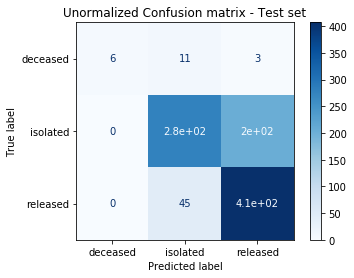

<Figure size 720x720 with 0 Axes>

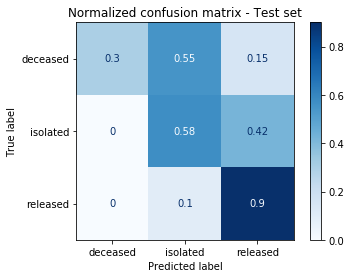

In [25]:
titles_options = [("Unormalized Confusion matrix - Test set", None),
                  ("Normalized confusion matrix - Test set", 'true')]
for title, normalize in titles_options:
    plt.figure(figsize=[10,10])
    disp = plot_confusion_matrix(rf, X_test, y_test,
                                 display_labels=np.unique(le.inverse_transform(y_test)),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

In [26]:
rf = RandomForestClassifier(max_depth=5, random_state=0)
rf.fit(ml_subset_final, labels)
print('Accuracy on the train set is {:.2f} %'.format(np.sum(rf.predict(ml_subset_final) == labels)/len(labels)*100))
importances = pd.DataFrame(rf.feature_importances_, columns=['Importance'])
importances['Feature'] = ['Underlying Disease','Age','Symptoms Existance','Sex','Infected by other',
                         'Country','Province']
train_chart_importance = alt.Chart(importances).mark_bar().encode(
    x = 'Importance:Q',
    y=alt.Y('Feature:N', sort='-x')
).properties(
    width = 300,
    height = 300,
    title = 'Random Forest Importance Factors directly on train set'
)

Accuracy on the train set is 74.22 %


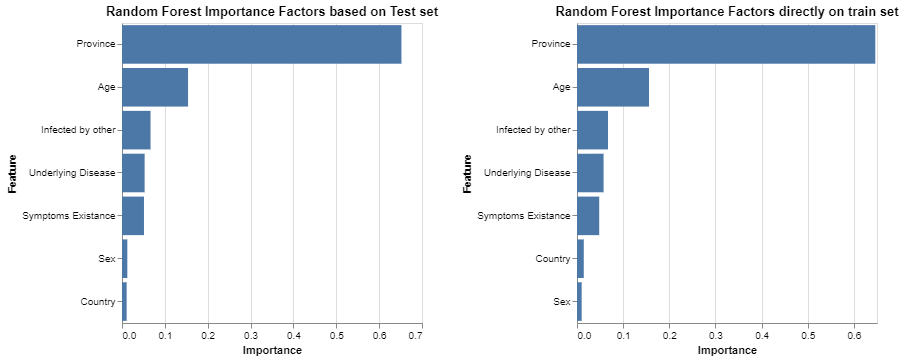

In [27]:
(test_set_importance) | (train_chart_importance)

<Figure size 720x720 with 0 Axes>

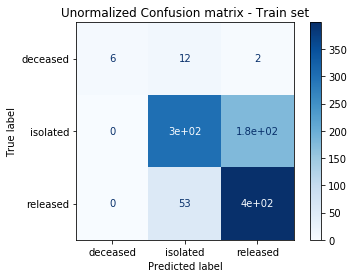

<Figure size 720x720 with 0 Axes>

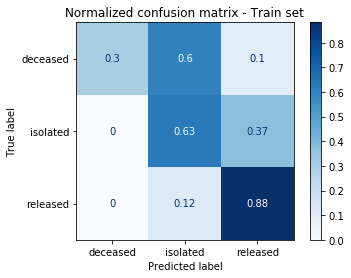

In [28]:
titles_options = [("Unormalized Confusion matrix - Train set", None),
                  ("Normalized confusion matrix - Train set", 'true')]
for title, normalize in titles_options:
    plt.figure(figsize=[10,10])
    disp = plot_confusion_matrix(rf, X_test, y_test,
                                 display_labels=np.unique(le.inverse_transform(y_test)),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()